<a href="https://colab.research.google.com/github/gmehra123/data_science_projs/blob/main/Probaility_distributions_and_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Probability distributions

* We look at some probability distributions that might be useful for us

In [181]:
# if you need to generate a normal distribution
var1 = np.random.normal(20,4,1000)



In [183]:
def plot_hist(var,size=(10,6),cumulative=False):
  """ Function to plot a histogram

  Parameters:
  ----------
  var: series/numpy array

  Returns:
  --------
  plt.show(): figure show object
  shows a figure"""
  fig,ax = plt.subplots(figsize = size)
  sns.histplot(var,cumulative=False,kde=True)
  plt.show()



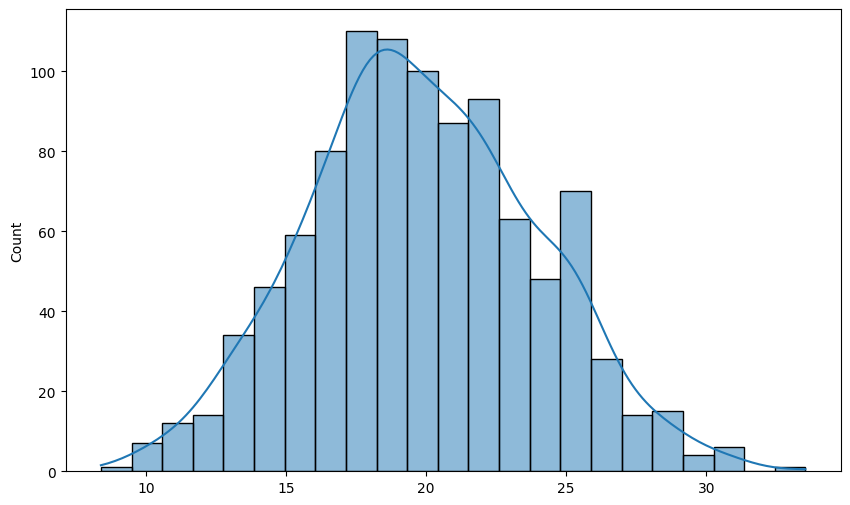

In [184]:
plot_hist(var1,size=(10,6))

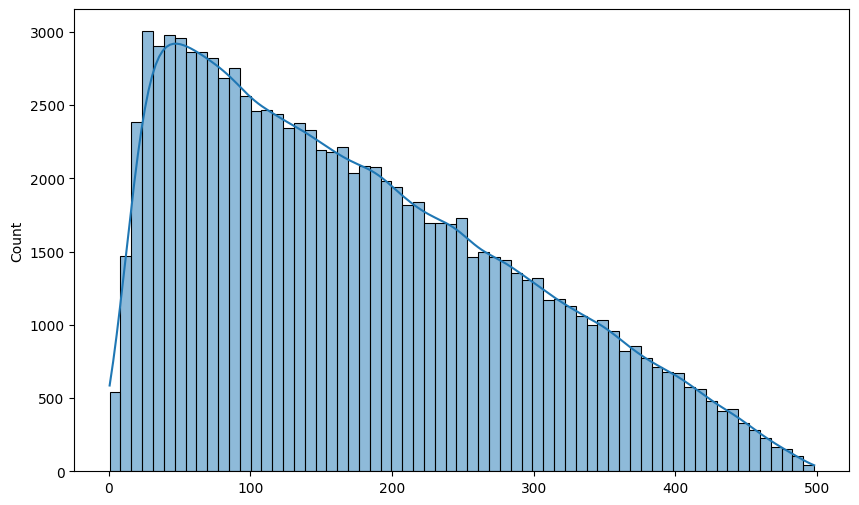

In [237]:
# if you need to model a skewed distribution an easy way is to use triangular distribution.
var2 = np.random.triangular(left = 0, mode = 25, right =500,size = 100000)
plot_hist(var2,size=(10,6))

### Problem statement
* We are given avg monthly energy consumption for a set of 26K customers for company A
* We want to find what is the lifetime revenue of a **typical customer** of company A in dollars with a confidence interval around the estimate, not just a **point estimate**.
* Simplifying assumption is that all customers rates can vary between 7 cents to 10 cents a KWh,for each month (think of them as Adjustable MTM customers) varying uniformly
* Losses can vary between 0.2% a month to 3% a month with the lost likely value being 0.9% a month
* Rev = consumption * rate * surv_prob
* 3 varying inputs give us the revenue
  * consumption
  * rate
  * surv_prob

##### First we find the distribution that most closely resembles the distribution of usage

In [207]:
# Get the consumption data
cons = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/sims.xlsx')

In [239]:
cons.head(5)

,Cust_Id,usage
0,1,216
1,2,210
2,3,225
3,4,216
4,5,222


In [240]:
cons.shape

(26496, 2)

In [241]:
cons.rename(columns={'electricity_consumption': 'usage'},inplace=True)

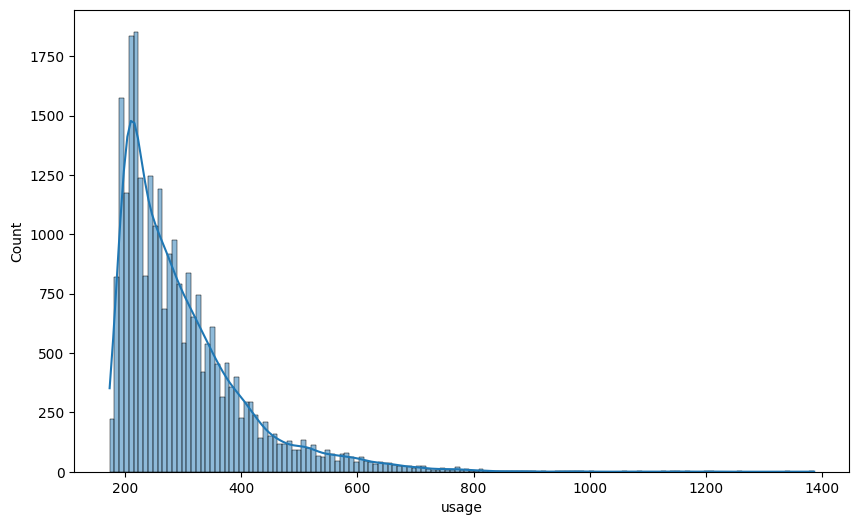

<Axes: >

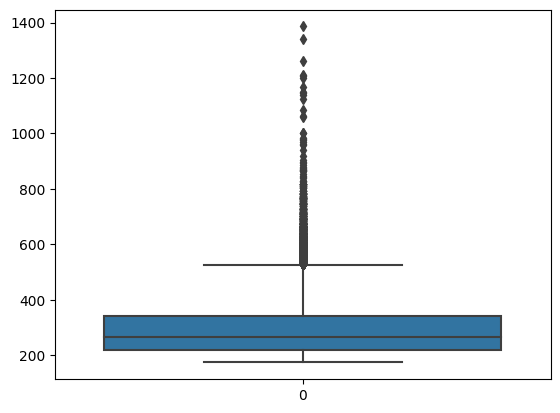

In [242]:
plot_hist(cons.usage)
sns.boxplot(cons.usage)

* The distribution is highly skewed
* A normal distribution would not fit this data very well
* box plot shows outliers beyond the whiskers

The normal distribution is centered at 298.3596014492754


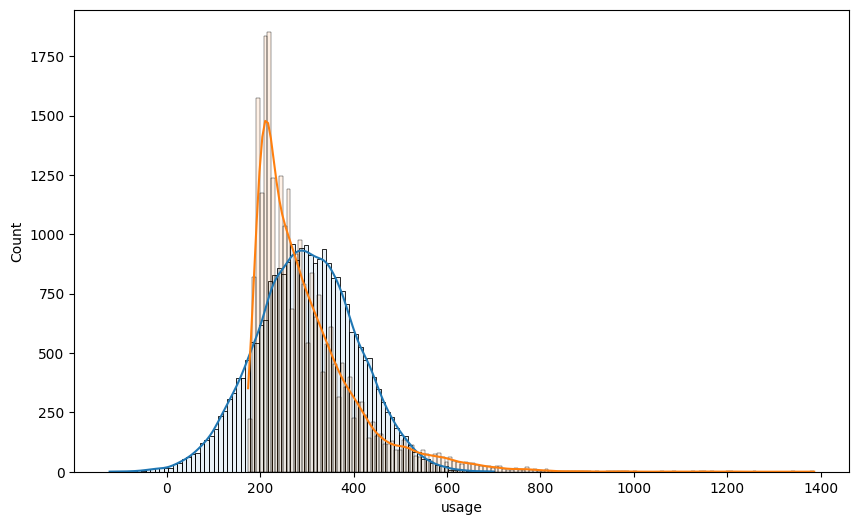

In [243]:
# Visually see how a normal distribution with the same mean and std distribution looks
mean = cons.usage.mean()
std_dev = cons.usage.std()
cons_normal = np.random.normal(mean,std_dev,cons.shape[0])
fig,ax = plt.subplots(figsize = (10,6))
sns.histplot(cons_normal,kde = True, alpha=0.1)
sns.histplot(cons.usage,kde = True, alpha=0.1)
print("The normal distribution is centered at", cons.usage.mean())

* When we overlay the simulated normal distribution it needs to be close to the actual distribution
* We will now try triangular distribution

210.0
174


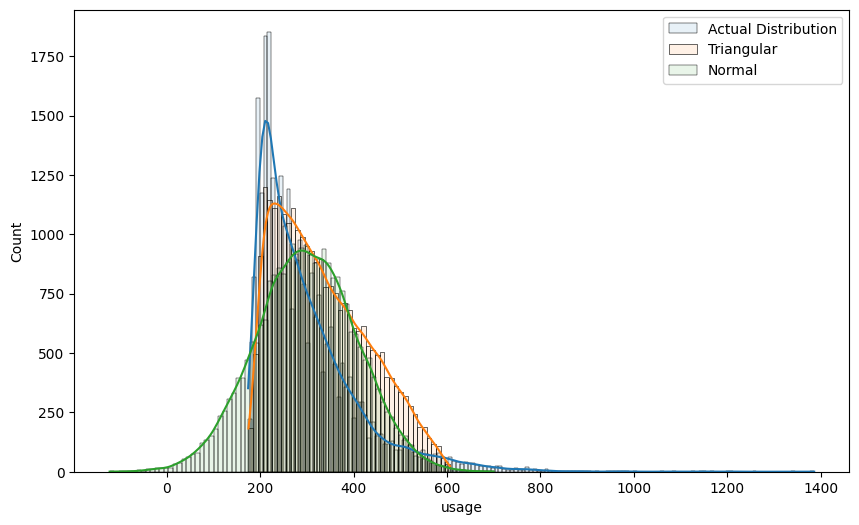

In [244]:
# Lets now overlay a triangular distribution to see if it fits the data
mode_ = cons.usage.mode()[0]
left = cons.usage.min()
right = np.percentile(cons.usage,98)
print(mode)
print(left)
cons_triangular = np.random.triangular(left,mode_,right,cons.usage.shape[0])

fig,ax = plt.subplots(figsize=(10,6))
sns.histplot(cons.usage,kde = True, alpha=0.1,label='Actual Distribution')
sns.histplot(cons_triangular,kde=True,alpha=0.1,label = "Triangular")
sns.histplot(cons_normal,kde = True, alpha=0.1, label ='Normal')
plt.legend()

In [224]:
# Another way is to use scipy.stats skewnorm to find the parameters for the best fit skewed distribution
from scipy.stats import skewnorm
estimated_skewness, estimated_location, estimated_scale = skewnorm.fit(cons.usage)
print(estimated_skewness)
print(estimated_location)
print(estimated_scale)

36.953561589277314
181.67016917472782
159.01072973581503


In [229]:
# Creating the skewed normal distribution and then seeing how it fits the data
skewed_norm = skewnorm.rvs(estimated_skewness, loc = estimated_location,
             scale = estimated_scale, size = cons.shape[0] )

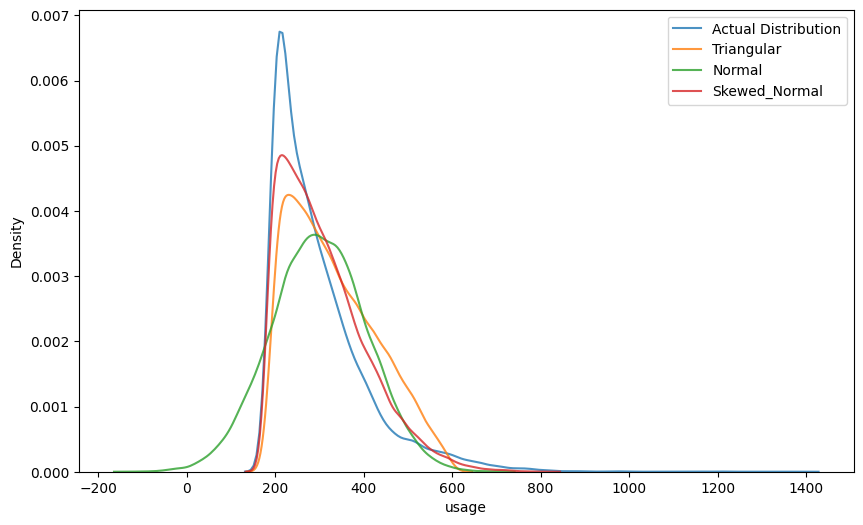

In [245]:
# The skewed normal distribution best fits the usage data
fig,ax = plt.subplots(figsize=(10,6))
sns.kdeplot(cons.usage, alpha=0.8,label='Actual Distribution')
sns.kdeplot(cons_triangular,alpha=0.8,label = "Triangular")
sns.kdeplot(cons_normal, alpha=0.8, label ='Normal')
sns.kdeplot(skewed_norm, alpha=0.8, label ='Skewed_Normal')
plt.legend()

### Putting it together all together
* Customer lifetime is 60 months
* We will generate 60 samples for 60 months of usage drawn from the skewed normal distribution that best fits the usage data
* We generate 60 samples from the price distribution
* We generate 60 samples for the loss/survival distribution
* We then multiply to get rev

In [252]:
usage = skewnorm.rvs(estimated_skewness, loc = estimated_location,
             scale = estimated_scale, size = 60 )
usage

array([271.05247949, 245.59580529, 249.90875597, 542.41067283,
       255.41896304, 396.50111757, 461.88025164, 287.50167112,
       368.06104938, 295.94473668, 224.70529008, 185.19029886,
       214.37563814, 440.65826546, 235.44060018, 291.5878785 ,
       196.66372511, 285.41014624, 237.18546863, 197.2201865 ,
       437.09968223, 293.27477505, 457.25736349, 412.83432526,
       188.29521755, 338.815333  , 205.33610278, 278.62040062,
       310.36106563, 223.36485502, 250.18942471, 191.78384026,
       243.51979277, 416.45694943, 367.34375189, 297.82953863,
       200.51331122, 259.09433142, 403.85137573, 408.89818973,
       273.33177314, 271.74894785, 267.23811957, 300.16248364,
       438.13171703, 336.50991454, 235.58226227, 206.69949274,
       279.01485085, 416.59044313, 301.36977267, 314.12415943,
       308.67371619, 404.20568126, 573.54412564, 298.24392521,
       428.16822079, 228.83244681, 374.21838893, 206.35745496])

In [273]:
loss_arr = np.random.uniform(low = 0.009, high= 0.03, size = 60)
print("The monthly loss \n",loss_arr,"\n")
cum_loss = loss_arr.cumsum()
print("The cumulative loss \n",cum_loss,"\n")
norm_cum_loss = np.where(cum_loss>1,1,cum_loss)
print("The cumulative loss normalized \n",norm_cum_loss,"\n")
surv = 1-norm_cum_loss
print("The cumulative surival curve \n", surv)

The monthly loss 
 [0.02610326 0.0131587  0.01113743 0.02429234 0.02195662 0.01000737
 0.01894217 0.02694906 0.01861194 0.01276893 0.01813983 0.01178295
 0.0104825  0.02091705 0.02588456 0.02315007 0.01391092 0.01408835
 0.01064368 0.02257554 0.0231563  0.02846517 0.01111872 0.01010158
 0.00989723 0.02568113 0.01694565 0.02618663 0.01248069 0.01255765
 0.01599796 0.01740948 0.02932239 0.017458   0.01846596 0.01969934
 0.01668865 0.02310479 0.01746158 0.0245664  0.02635702 0.0170151
 0.00904745 0.02481865 0.01525354 0.01422685 0.01342234 0.01322116
 0.02629667 0.01820722 0.01232245 0.02659877 0.00951429 0.02419146
 0.02169787 0.01991775 0.01576358 0.02898951 0.01930181 0.0196461 ] 

The cumulative loss 
 [0.02610326 0.03926196 0.05039939 0.07469172 0.09664834 0.10665571
 0.12559788 0.15254693 0.17115887 0.1839278  0.20206763 0.21385058
 0.22433308 0.24525013 0.27113469 0.29428476 0.30819568 0.32228403
 0.3329277  0.35550324 0.37865955 0.40712472 0.41824344 0.42834502
 0.43824225 0.46392

In [274]:
rev_rate = np.random.uniform(low = 0.07, high = 0.10, size = 60)

In [279]:
usage = skewnorm.rvs(estimated_skewness, loc = estimated_location,
             scale = estimated_scale, size = 60 )
rev_rate = np.random.uniform(low = 0.07, high = 0.10, size = 60)
# generating surv samples
loss_arr = np.random.uniform(low = 0.009, high= 0.03, size = 60)
cum_loss = loss_arr.cumsum()
norm_cum_loss = np.where(cum_loss>1,1,cum_loss)
surv = 1-norm_cum_loss
revenue_arr = usage * rev_rate * surv
print("lifetime rev array \n",revenue_arr, "\n")
life_rev = revenue_arr.sum()
print("The total lifetime rev \n", life_rev)

lifetime rev array 
 [26.70460507 41.70591108 20.0911689  51.36017427 32.23906738 27.5802258
 24.33913235 19.53098344 21.89502102 11.32076631 17.323828   20.36857351
 13.70278246 20.94491267 14.33018458 13.32691882 27.00612744 14.21048319
 17.66099205 21.53110925 10.8551196  12.63630006 14.82420464 13.39335819
 10.95940289 17.01623428 11.83340568 11.82073367  9.6403488   6.2376584
 13.93555411  5.18608877 11.5220406   4.32702973  9.06626383  6.51294325
  5.64428469  5.37920784  3.70635424  3.83422367  3.0318623   2.41215843
  2.69459048  1.96941717  3.30405013  2.20570764  1.10354033  0.40166372
  0.30804702  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ] 

The total lifetime rev 
 662.9347617297803


In [280]:
# Now running in a loop generating 1000 simulations
# Empty array to strore revenue results
arr=np.empty(1000)
for i in range(1,1000):
  usage = skewnorm.rvs(estimated_skewness, loc = estimated_location,
             scale = estimated_scale, size = 60 )
  rev_rate = np.random.uniform(low = 0.07, high = 0.10, size = 60)
  # generating surv samples
  loss_arr = np.random.uniform(low = 0.009, high= 0.03, size = 60)
  cum_loss = loss_arr.cumsum()
  norm_cum_loss = np.where(cum_loss>1,1,cum_loss)
  surv = 1-norm_cum_loss
  revenue_arr = usage * rev_rate * surv
  life_rev = revenue_arr.sum()
  arr[i] = life_rev


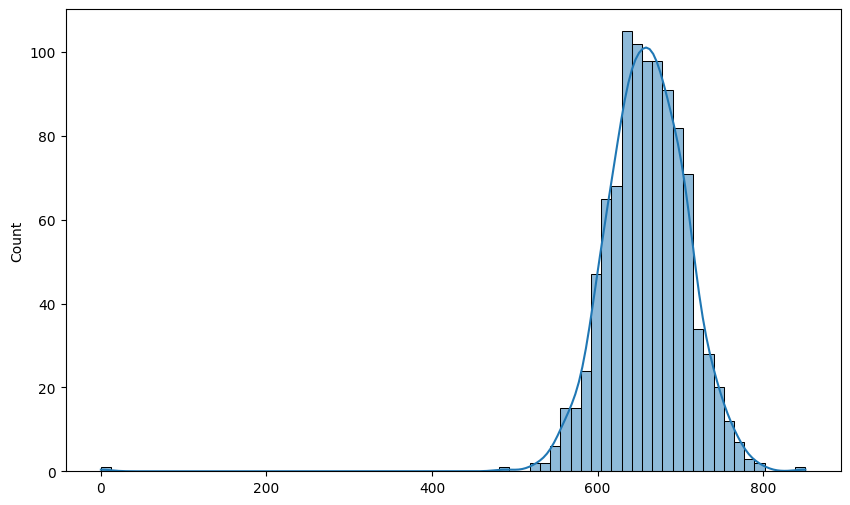

the median value of a typical customer is 660.21
95% CI for typical customer lifetime rev [587.29177406 738.16035157]


In [287]:
plot_hist(arr)
print("the median value of a typical customer is", round(np.median(arr),2))
print("95% CI for typical customer lifetime rev",np.percentile(arr,[5,95]))